In [1]:
import numpy as np
import matplotlib

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
from scipy.misc import derivative
from scipy.integrate import solve_bvp
from functools import partial
from scipy import special as sp
from scipy import stats
import plasmapy
import scipy.optimize as op

from scipy import fftpack
from scipy import integrate
from scipy import signal

%config InlineBackend.figure_format = 'svg'

In [138]:
tem = 1
k = 0.05
L =  2*np.pi/k
vmax = 10  # 10 * np.sqrt(tem)
nx = 200
nv = 500
dt = 0.03
max_steps  = 10000
data_steps = max_steps

uae = 0.82
uai = 0.8

In [139]:
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
V, X = np.meshgrid(v, x)

data_num = int(max_steps/data_steps) + 1
path = '../data/'

m=1
n=1
q=1
v_th = np.sqrt(2*tem)
l_D = np.sqrt( tem) # $\lambda_D^2$
w_pe = 1
print("data_num = ",data_num)

data_num =  2


No handles with labels found to put in legend.


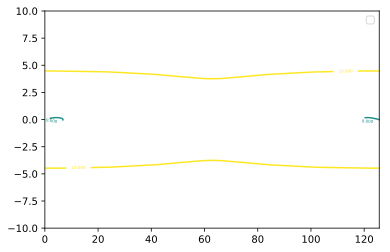

In [151]:
EK, PHI = np.meshgrid(0.5*v**2,phi[data_num-1])
ENERGY = EK-PHI
cf = plt.contour(X,V,ENERGY,levels=[-10,0,10])
plt.clabel(cf,inline=True,fontsize=4)
plt.legend()
plt.show()

In [108]:
def eq4PDRM(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta = wc / k /v_th
    r = 1 + 1 / k**2 / l_D**2 * ( 1 + zeta*plasmapy.dispersion.plasma_dispersion_func(zeta) )
    return [r.real,r.imag]
#kvec = np.arange(.1,1.2,0.1)
print("k = ",k)
s=op.root(lambda w:eq4PDRM(w,k),[1,0.1])
v_p = s.x[0]/k
print("w_r = ",s.x[0])
print("w_i = ",s.x[1])
print("v_p = ",v_p)
print("t_Bi = ", abs(1/np.sqrt(q*abs(uae-uai))))
#print("t_Bf = ", abs(1/np.sqrt(q*abs(ff(L/2)-uai))))
print("t_L = ", abs(1/s.x[1]))
print('limited time=',2*np.pi/k/dv)
print('real time = ', max_steps*dt)

k =  0.05
w_r =  1.003761865294658
w_i =  -5.346001938602098e-14
v_p =  20.07523730589316
t_Bi =  7.071067811865492
t_L =  18705567477992.453
limited time= 25.132741228718345
real time =  300.0


In [109]:
def fm(v, t):
    r = np.sqrt(1./(2.*np.pi*t))*np.exp(-v**2/(2*t))
    return r
def fk(v, t, kappa):
    if(kappa == 0):
        r = fm(v, t)
    else:
        r = np.sqrt(m/(2.*np.pi*t*kappa)) * sp.gamma(kappa+1.5) / \
            sp.gamma(kappa+1) * (1 + m*v**2 / kappa / 2 / t) ** (-kappa-1.5)
    return r
def ue(x):
    r = 1.+uae*np.cos(2.*np.pi*x/L)
    return r
def ui(x):
    r = 1.+uai*np.cos(2.*np.pi*x/L)
    return r
def fk_xv(x,v,k,t):
    if(k==0):
        s = fx_theo(x)*np.sqrt( fx_theo(x)**( 1./(k+1) ) / (2*np.pi*t) )/L
        m = np.exp(-v**2 / (2*t) * fx_theo(x)**(1./(k+1)))
        r = s*m
    else:
        s = fx_theo(x)*np.sqrt( fx_theo(x)**( 1./(k+1) ) / (2*np.pi*t*k) )/L
        frac = sp.gamma(k+1.5) / sp.gamma(k+1)
        m = ( 1+ (v)**2 / (k*2*t) * fx_theo(x)**(1./(k+1)) )**(-k-1.5)
        r = s*frac*m
    return r.real
def fk_v_nonvec(vv,kk,tt):
    r = integrate.quad(partial(fk_xv,v=vv,k=kk,t=tt),0,L)[0]
    return r
fk_v = np.vectorize(fk_v_nonvec)

In [140]:
progesses = np.arange(0,data_num,1)

f = []
phi = []

for progess in progesses:
    f_temp = np.loadtxt(os.path.join(path,"data"+str(progess)))
    f.append(f_temp)
    phi_temp = np.loadtxt(os.path.join(path,"phi"+str(progess)))
    phi.append(phi_temp)

In [141]:
dataet = np.loadtxt(os.path.join(path, "tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path, "pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path, "kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

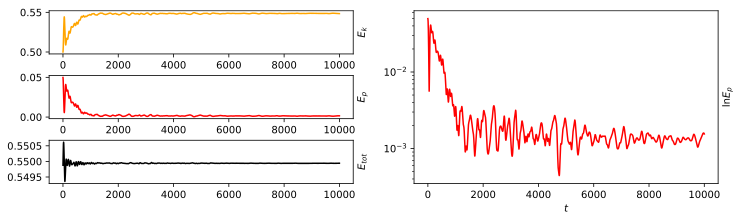

In [142]:
fig = plt.figure(figsize=(12, 3))

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 2), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.2)
plt.xlabel(r'$t$')
plt.show()

In [143]:
energy_i=dataet[0]
energy_f=dataet[max_steps-1]

print("E_i = ",energy_i)
print("E_f = ",energy_f)
print("E_erro = ",abs(energy_i-energy_f)/energy_i*100,'%')

def entropy_calc(f):
    s = 0.0
    for i in f.flatten():
        s += (i/L)**2
        #if (i>0):
            #s += -i/L * np.log(i/L)
    return s*dx*dv

entropy_i = entropy_calc(f[0])
entropy_f = entropy_calc(f[data_num-1])
print('S_i= ',entropy_i)
print('S_f= ',entropy_f)
print('S_erro=', abs(entropy_f-entropy_i)/entropy_i*100, "%")

E_i =  0.5498772953286
E_f =  0.5499413264215
E_erro =  0.011644614797510638 %
S_i=  0.003306571137544598
S_f=  0.0032324880001449187
S_erro= 2.2404821888904562 %


### 分布函数fx fv

In [144]:
fx0 = np.sum(f[0],axis=1)*dv
fv0 = np.sum(f[0],axis=0)*dx/L
fx = np.sum(f[data_num-1],axis=1)*dv
fv = np.sum(f[data_num-1],axis=0)*dx/L
T0 = np.sum(v**2*f[0],axis=1)*dv/fx0
T = np.sum(v**2*f[data_num-1],axis=1)*dv/fx

In [145]:
grad_p = np.diff(fx*T)/dx
grad_p = np.append(grad_p, grad_p[0])
grad_phi = np.diff(phi[data_num-1])/dx
grad_phi = np.append(grad_phi, grad_phi[0])

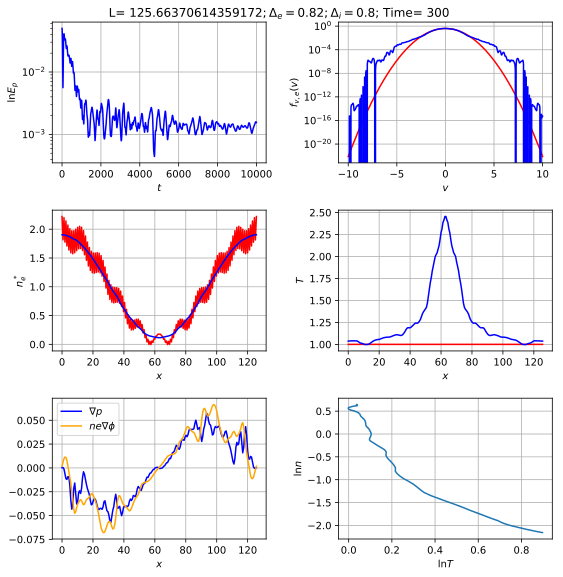

In [146]:
fig = plt.figure(figsize=(8, 8))

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.plot(t, dataep, color='blue')
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$\ln E_p$')
ax1.set_yscale('log')
ax1.grid()

ax2 = plt.subplot2grid((3, 2), (0, 1))
ax2.plot(v, fv0, color='red', label='intial')
ax2.plot(v, fv, color='blue', label='simulation')
ax2.set_xlabel(r'$v$')
ax2.set_ylabel(r'$f_{v,e}(v)$')
ax2.set_yscale('log')
ax2.grid()

ax3 = plt.subplot2grid((3, 2), (1, 0))
ax3.plot(x, fx0, color='r', label='initial')
ax3.plot(x, fx, color='blue', label='final')
ax3.set_xlabel(r'$x$')
ax3.set_ylabel(r'$n_e^*$')
ax3.grid()

ax4 = plt.subplot2grid((3, 2), (1, 1))
ax4.plot(x, T0, color='r', label='initial')
ax4.plot(x, T, color='blue', label='final')
ax4.set_xlabel(r'$x$')
ax4.set_ylabel(r'$T$')
ax4.grid()

ax5 = plt.subplot2grid((3, 2), (2, 0))
ax5.plot(x,grad_p,color='blue', label=r'$\nabla p$')
ax5.plot(x,fx*grad_phi,color='orange', label=r'$ne\nabla \phi$')
ax5.set_xlabel(r'$x$')
ax5.legend()
ax5.grid()

ax6 = plt.subplot2grid((3, 2), (2, 1))
ax6.plot(np.log(T),np.log(fx))
ax6.set_xlabel(r'$\ln T$')
ax6.set_ylabel(r'$\ln n$')
ax6.grid()

title_text = "L= " + str(L) + r"$; \Delta_e= $" + str(uae) + r"$; \Delta_i= $" + str(uai) + "; Time= " + str(int(dt*max_steps))
fig.suptitle(title_text, va='bottom')
plt.tight_layout()
plt.show()

In [147]:
p=stats.linregress(np.log(T),np.log(fx))
print(p)
kappa_sim = -p.slope-1
print('kappa_sim = ', kappa_sim)

LinregressResult(slope=-3.488610861305036, intercept=0.42777418203624695, rvalue=-0.9522575993210636, pvalue=5.607611433107089e-104, stderr=0.07948518217445207)
kappa_sim =  2.488610861305036


In [148]:
def fk(v, t, kappa):
    if(kappa == 0):
        r = fm(v, t)
    else:
        r = np.sqrt(m/(2.*np.pi*t*kappa)) * sp.gamma(kappa+1.5) / \
            sp.gamma(kappa+1) * (1 + m*v**2 / kappa / 2 / t) ** (-kappa-1.5)
    return r

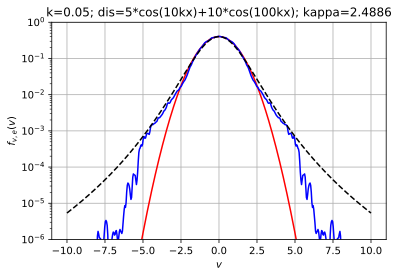

In [149]:
plt.plot(v, fv0, color='red', label='intial')
plt.plot(v, fv, color='blue', label='simulation')
plt.plot(v, fk(v,  T.mean(),kappa_sim),'--', color='black', label='theo')
plt.xlabel(r'$v$')
plt.ylabel(r'$f_{v,e}(v)$')
plt.yscale('log')
plt.ylim(1e-6,1)
plt.title('k='+str(k)+'; dis=5*cos(10kx)+10*cos(100kx)'+'; kappa='+str(round(kappa_sim,4)))
plt.grid()
plt.show()

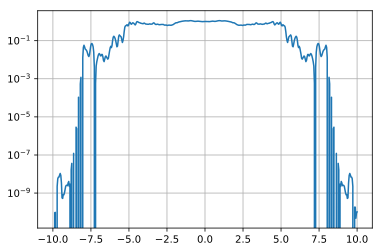

In [150]:
plt.plot(v,fv/fk(v,T.mean(),kappa_sim))
plt.yscale('log')
plt.grid()
plt.show()